# Load library

In [50]:
import os
if not os.getcwd().endswith('m6A'):
    os.chdir('m6A/')
    
%load_ext rpy2.ipython
%env PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/homer/bin
from scripts.common import *

data_folder='/home/dengw1/workspace/mouse_lowinput/'

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
env: PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/homer/bin


In [51]:
%%R
source('scripts/common.r')
data_folder<-'/home/dengw1/workspace/mouse_lowinput/'

# Filter peaks with input RPKM < 5 in > 66 samples

In [ ]:

if not os.path.isdir('WGCNA'):
    os.mkdir('WGCNA')

first=True
tagged_peaks=open('m6A_data/tagged_peak_intensity.csv','w')
for line1,line2 in zip(open('m6A_data/input_peak.RPKM.csv'),open('m6A_data/peak_intensity.csv')):
    if first:
        tagged_peaks.write(line2)
        first=False
        continue
    info1=line1.strip().split('\t')
    info2=line2.strip().split('\t')
    count=0
    for i in range(1,len(info1)):
        if float(info1[i])<5:
            info2[i]='NA'
    if info2.count('NA')<66:
        tagged_peaks.write('\t'.join(info2)+'\n')
tagged_peaks.close()

total_peaks=set(pd.read_csv('m6A_data/tagged_peak_intensity.csv',sep='\t',index_col=0,header=0).index)
idr_peaks=pd.read_csv('m6A_data/peak_intensity_m_1_renamed_gmean.csv',sep='\t',header=0,index_col=0)
idr_peaks=quantile_normalize(idr_peaks)
idr_peaks['peak_id']=[':'.join(x.split(':')[:4]) for x in idr_peaks.index]
idr_peaks=idr_peaks[idr_peaks['peak_id'].isin(total_peaks)]
idr_peaks=idr_peaks.drop('peak_id',axis=1)
idr_peaks.to_csv('WGCNA/filtered_idr_peaks.csv',quoting=csv.QUOTE_NONE,sep='\t')

# Module detection (All groups)
## Load data and preprocess, using CV>0.3 as threshold

In [3]:
%%R
library(WGCNA)
options(stringsAsFactors = FALSE)
enableWGCNAThreads()

data<-read.table('WGCNA/filtered_idr_peaks.csv',sep='\t',check.names = F,row.names=1,header=T)
cvs<-apply(data,1,cv)
vdata<-subset(data,cvs>=0.1)
dataExpr = as.data.frame(t(vdata));
names(dataExpr) = rownames(vdata)
rownames(dataExpr) = colnames(vdata)
gsg = goodSamplesGenes(dataExpr, verbose = 3);
if (!gsg$allOK){
    dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]}

sampleTree = hclust(dist(dataExpr), method = "average");

clust = cutreeStatic(sampleTree, cutHeight = 15, minSize = 10)
table(clust)
keepSamples = (clust==0)
dataExpr = dataExpr[keepSamples, ]
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
print(nGenes)

Allowing parallel execution with up to 95 working processes.
 Flagging genes and samples with too many missing values...
  ..step 1
[1] 22845


## Module detection with min block size of 30 (Figure4A)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..done.


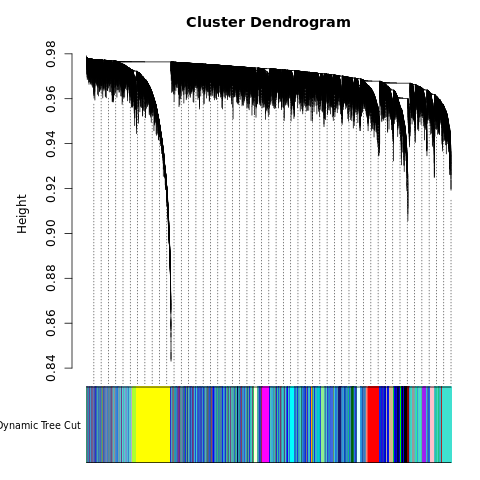

In [4]:
%%R
softPower = 6;
# Initialize an appropriate array to hold the adjacencies
adjacencies = array(0, dim = c(1, nGenes, nGenes));
# Calculate adjacencies in each individual data set
adjacencies[1, , ] = (0.5+0.5*cor(dataExpr, use = "p"))^softPower;

TOM = array(0, dim = c(1, nGenes, nGenes));
TOM[1, , ] = TOMsimilarity(adjacencies[1, , ]);

consTree = hclust(as.dist(1-TOM[1,,]), method = "average");

minModuleSize = 50;
unmergedLabels = cutreeDynamic(dendro = consTree, distM = 1-TOM[1, , ],
                               deepSplit = 2,cutHeight = 0.995,
                               minClusterSize = minModuleSize,pamRespectsDendro = FALSE );
unmergedColors = labels2colors(unmergedLabels)
pdf('figures/Figure4A_WGCNA_modules_idr.pdf',width=8,height=6)
plotDendroAndColors(consTree, unmergedColors, "Dynamic Tree Cut",dendroLabels = FALSE, 
                    hang = 0.03,addGuide = TRUE, guideHang = 0.05)
dev.off()

plotDendroAndColors(consTree, unmergedColors, "Dynamic Tree Cut",dendroLabels = FALSE, 
                    hang = 0.03,addGuide = TRUE, guideHang = 0.05)

labels<-paste0('M',unmergedLabels)
names(labels)<-colnames(dataExpr)
save(adjacencies,unmergedLabels,unmergedColors,file='WGCNA/WGCNA_module_data.RData')
write.csv(labels,file='WGCNA/WGCNA_module_labels.csv')

## Get peaks of all modules

In [ ]:
import yaml
import sys
from collections import defaultdict

module_peaks=defaultdict(list)
first=True
for line in open('WGCNA/WGCNA_module_labels.csv'):
    if first:
        first=False
    else:
        info=line.strip().replace('"','').split(',')
        peak=info[0].split(':')
        module_peaks[info[1]].append('%s\t%s\t%s\t.\t.\t%s'%tuple(peak))
# all_=open('m6A_data/All_peak.bed','w')
for module in module_peaks:
    out_file=open('WGCNA/%s_peak.bed'%module,'w')
    for peak in module_peaks[module]:
        if(len(peak)>0):
            out_file.write(peak+'\n')
    out_file.close()
# all_.close()

## Figure4B, Draw distributions 

In [ ]:
%%bash
python3 scripts/Peak_distribution_on_utr_cds.py ts_data/all_peak.bed hg19 > WGCNA/All.dist

for module in M1 M2 M3 M4 M5 M6 M7 M8 M9 M10
do
python3 scripts/Peak_distribution_on_utr_cds.py WGCNA/${module}_peak.bed hg19 > WGCNA/${module}.dist
done

In [ ]:
list_=['All']
for i in range(1,11):
    list_.append('M%s'%i)

dist_data=open('WGCNA/module_dist_data.txt','w')
for item in list_:
    count=1
    for line in open('WGCNA/%s.dist'%item):
        info=line.strip().split('\t')
        dist_data.write('%s\t%s\t%s\n'%(item,count,info[1]))
        count=count+1

dist_data.close()

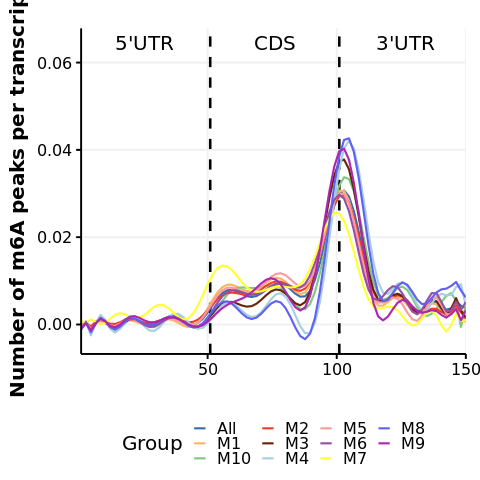

In [5]:
%%R
data<-read.table('WGCNA/module_dist_data.txt')
colnames(data)<-c('Group','X','Y')

sep1=51
sep2=101
p=ggplot(data,aes(x=X,y=Y,color=Group))+geom_vline(xintercept=c(sep1, sep2), linetype='dashed', size = 1.2) +
    annotate('text', 
             label=c("5'UTR", "CDS", "3'UTR"), 
             size = 7,
             x=c( sep1/2, (sep1+sep2)/2, sep2+sep1/2 ), 
             y=max(data[,3])*0.9) +  
    stat_smooth(aes(x=X,y=Y,color=Group), method = "lm", formula = y ~ poly(x, 21), se = FALSE)+
    scale_x_continuous(expand=c(0,0)) + 
ylab('Number of m6A peaks per transcript')+scale_colour_Publication()+theme_Publication()+xlab('')

pdf('figures/Figure4B_WGCNA_Module_distribution.pdf',width=6)
print(p)
dev.off()
print(p)

## Call motifs (TODO: add code of downloading ENCODE peaks)

In [ ]:
%%bash
for module in M6 M2 M3 M4 M5 M1 M7 M8 M9 M10
do
findMotifsGenome.pl WGCNA/${module}_peak.bed hg19 WGCNA/${module}_motif/ -rna \
    -len 5,6,7 -size 100 -S 10 
done 
mkdir -p WGCNA/ENCODE_motifs

In [ ]:
cmd='''#!/usr/bin/bash
findMotifsGenome.pl WGCNA/RBP_peaks/ENCODE_peaks/{rbp}-human.sorted.bed hg19 \
    WGCNA/ENCODE_motifs/{rbp}/ -rna -len 5,6,7 -size 50 -S 10 
'''
for file_ in os.listdir('WGCNA/RBP_peaks/ENCODE_peaks'):
    if file_.endswith('-human.sorted.bed'):
        rbp=file_.split('-')[0]
        with open('tmp/%s.sh'%rbp,'w') as fo:
            fo.write(cmd.format(rbp=rbp))
            fo.close()
        subprocess.call('sbatch --job-name=%s -N 1 -n 10 \
                        --mem=10G -t 0-00:20:00 tmp/%s.sh'%(rbp,rbp),shell=True)

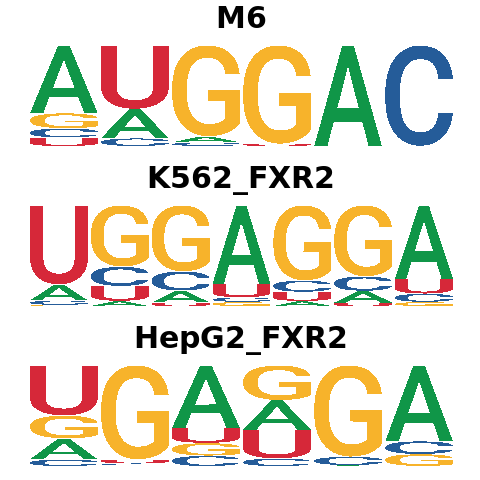

In [7]:
%%R
# pdf('figures/WGCNA_motifs.pdf')

data<-read.table('WGCNA/M6_motif/homerResults/motif1.motif',skip=1,header=F,sep='\t')
data<-t(data)
rownames(data)<-c('A', 'C', 'G', 'U')
p1 <- ggplot() + geom_logo(data, method = 'prob') + theme_logo() + theme(axis.text.x = element_blank(), 
       panel.spacing = unit(0.5, 'lines'),
       axis.text.y = element_blank(), 
       axis.title.y = element_blank(),
       axis.title.x = element_blank(), 
       plot.title = element_text(hjust = 0.5, size=30, face='bold'),
       legend.position = 'none') + ggtitle('M6')
data<-read.table('WGCNA/ENCODE_motifs/K562_FXR2/homerResults/motif1.motif',skip=1,header=F,sep='\t')
data<-t(data)
rownames(data)<-c('A', 'C', 'G', 'U')
p2 <- ggplot() + geom_logo(data, method = 'prob') + theme_logo() + theme(axis.text.x = element_blank(), 
       panel.spacing = unit(0.5, 'lines'),
       axis.text.y = element_blank(), 
       axis.title.y = element_blank(),
       axis.title.x = element_blank(), 
       plot.title = element_text(hjust = 0.5, size=30, face='bold'),
       legend.position = 'none') + ggtitle('K562_FXR2')
data<-read.table('WGCNA/ENCODE_motifs/HepG2_FXR2/homerResults/motif1.motif',skip=1,header=F,sep='\t')
data<-t(data)
rownames(data)<-c('A', 'C', 'G', 'U')
p3 <- ggplot() + geom_logo(data, method = 'prob') + theme_logo() + theme(axis.text.x = element_blank(), 
       panel.spacing = unit(0.5, 'lines'),
       axis.text.y = element_blank(), 
       axis.title.y = element_blank(),
       axis.title.x = element_blank(), 
       plot.title = element_text(hjust = 0.5, size=30, face='bold'),
       legend.position = 'none') + ggtitle('HepG2_FXR2')


p<-ggarrange(p1,p2,p3,heights = c(1, 1),ncol = 1, nrow = 3, align = 'v')
pdf('figures/Figure4E_WGCNA_motifs.pdf')
print(p)
dev.off()
print(p)


# Correlated RBPs

## Use result of module detection (min=50) 
Calculate m6A index of all modules, use it to calculate correlated expression of RBP

In [11]:
%%R
data<-read.table('WGCNA/filtered_idr_peaks.csv',sep='\t',row.names = 1,header=T)
cvs<-apply(data,1,cv)
vdata<-subset(data,cvs>0.1)
write.csv(vdata,'WGCNA/filtered_idr_peak_intensity.csv')

## Figure4C, calculate m6A index of all modules, use it to calculate correlated expression of RBP

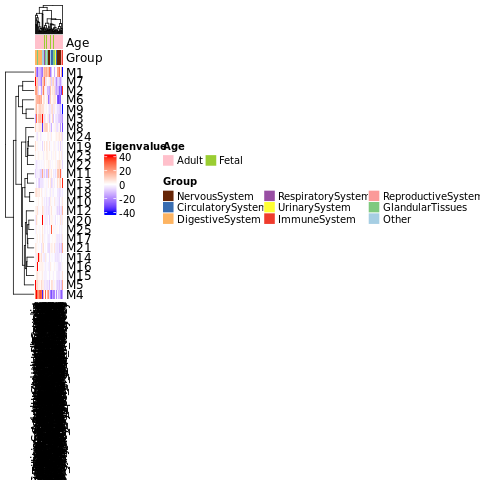

In [13]:
%%R
ht_opt$message = FALSE
vdata<-read.table('WGCNA/filtered_idr_peak_intensity.csv',sep=',',header=T,row.names=1, stringsAsFactor=F)
modules=read.csv('WGCNA/WGCNA_module_labels.csv', stringsAsFactor=F)


spl<-t(as.data.frame(strsplit(colnames(vdata),'_')))
colnames(spl)<-c('Group','Age','Tissue')
tissue_group<-as.vector(spl[,'Group'])
tissue_age<-as.vector(spl[,'Age'])

# peak_num_<-read.csv('WGCNA/peak_num',sep='\t',header=F,row.names=1)
# peak_num_<-peak_num_[colnames(mat),1]

group_color=c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")
names(group_color)<-unique(tissue_group)

column_ha=HeatmapAnnotation(
  Age=tissue_age,
  Group=tissue_group,
#   peak_num = anno_barplot(peak_num_,gp = gpar(fill =group_color[tissue_group]),width = unit(2, "cm")),
  col=list(Age=c("Adult"="pink","Fetal"="yellowgreen"),Group=group_color),
  annotation_legend_param = list(
      Age = list(direction = "horizontal",nrow = 1),
      Group = list(direction = "horizontal",nrow = 3,at=c("NervousSystem","CirculatorySystem","DigestiveSystem",
                                                          "RespiratorySystem","UrinarySystem","ImmuneSystem",
                                                          "ReproductiveSystem","GlandularTissues","Other")))
)

pdf('figures/WGCNA_Module_m6A_index.pdf',width=25,height=15)
indexes=modules[modules$x=='M1',]$X
module_data=vdata[as.character(indexes),]

Heatmap(t(scale(t(module_data))),name='z-score', col=colorRamp2(c(-4, 0, 4), c("blue", "white", "red")), 
         top_annotation = column_ha,show_row_dend=F,show_row_names = F,column_title = 'M1', 
   column_title_gp = gpar(fontsize = 20, fontface = "bold"))
pca_mat=prcomp(t(module_data),center=T,scale.=T)
eigen_values=pca_mat$x[,1]

for(i in seq(from=2,to=25,by=1)){
    cur_m=paste0('M',i)
    indexes=modules[modules$x==cur_m,]$X
    module_data=vdata[as.character(indexes),]
    ht=Heatmap(t(scale(t(module_data))),name='z-score', col=colorRamp2(c(-4, 0, 4), c("blue", "white", "red")), 
           top_annotation = column_ha,show_row_dend=F,show_row_names = F,column_title = cur_m, 
           column_title_gp = gpar(fontsize = 20, fontface = "bold"))
    draw(ht)
    pca_mat=prcomp(t(module_data),center=T,scale.=T)
    eigen_values=rbind(eigen_values,M=pca_mat$x[,1])
}
dev.off()
row.names(eigen_values)<-paste0('M',seq(from=1,to=25,by=1))
write.csv(eigen_values,'WGCNA/WGCNA_Eigenvalues.csv')
pdf('figures/Figure4C_WGCNA_Eigenvalues.pdf',width=25,height=15)
ht=Heatmap(eigen_values,name='Eigenvalue', col=colorRamp2(c(-40, 0, 40), c("blue", "white", "red")),
           top_annotation = column_ha,show_row_dend=T,show_row_names = T)
draw(ht)
dev.off()
draw(ht)


## Export expression of eCLIP RBPs (TODO: generate or provide RBP_list.txt and ensg_gn.txt)

In [ ]:
%%R
valid_ensg<-read.table('WGCNA/RBP_list.txt', stringsAsFactor=F)$V1
ensg_gn<-unique(read.table('gtf/ensg_gn.txt',header=F, stringsAsFactor=F))
gene_exp<-read.table('m6A_data/FA233_exp_all_tx_mean.txt', stringsAsFactor=F)

valid_gene_exp<-gene_exp[as.character(valid_ensg),]
valid_gene_exp<- valid_gene_exp[rowSums(is.na(valid_gene_exp)) == 0,]
eigen_values=read.csv('WGCNA/WGCNA_Eigenvalues.csv',header=T)
row.names(eigen_values)<-eigen_values[,1]
eigen_values<-eigen_values[-1]
sds<-apply(valid_gene_exp,1,sd)
valid_gene_exp<-valid_gene_exp[sds>0,]
corr_table<-NULL
for(module in 1:nrow(eigen_values)){
  for(gene in 1:nrow(valid_gene_exp)){
    gene_name<-as.character(ensg_gn[ensg_gn$V1==row.names(valid_gene_exp[gene,]),]$V2)
    if(length(gene_name)==0){
        gene_name<-'NA'
    }
    eigen_<-as.numeric(eigen_values[module,])
    exp_<-as.numeric(valid_gene_exp[gene,])
    p<-cor.test(eigen_,exp_,method=c("pearson"))
    permute_p=c()
    for(i in 1:1000){
        eigen_p<-sample(eigen_)
        exp_p<-sample(exp_)
        p_value<-(cor.test(eigen_p,exp_p,method=c("pearson")))$p.value
        if(p_value<=p$p.value){
          permute_p[i]<-p_value
        }
    }
    ratio_=length(permute_p)/1000      
    if(abs(p$estimate)>0.3){
      if(is.null(corr_table)){
        corr_table<-c(row.names(eigen_values[module,]),ratio_,gene_name,
                      row.names(valid_gene_exp[gene,]),as.numeric(p$estimate),p$p.value)
      }else{
        corr_table<-rbind(corr_table,c(row.names(eigen_values[module,]),ratio_,gene_name,
                                       row.names(valid_gene_exp[gene,]),as.numeric(p$estimate),p$p.value))
      }
    }
   }
}
write.csv(corr_table,'WGCNA/WGCNA_Module_RBP_COR_full.txt',row.names=F,col.names=F)

## FigureS7
Draw heatmap of highly correlated gene expression in each group

png 
  2 


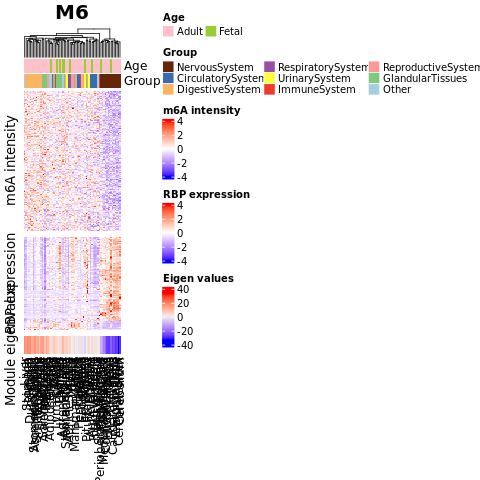

In [52]:
%%R
options(repr.plot.width=20, repr.plot.height=15)

## the correlation table file is manully modified to fix the format
col_fun = colorRamp2(c(-4, 0, 4), c("blue", "white", "red"))
# read in intensities
peak_intensity<-read.table('WGCNA/filtered_idr_peak_intensity.csv',sep=',',
                           header = T,row.names = 1)
modules=read.csv('WGCNA/WGCNA_module_labels.csv')
eigen_values=read.csv('WGCNA/WGCNA_Eigenvalues.csv',header=T)
row.names(eigen_values)<-eigen_values[,1]
eigen_values<-eigen_values[-1]
# read in and preprocess gene expression
gene_exp<-read.table('m6A_data/FA233_exp_all_tx_mean.txt',sep='\t',header = T,row.names = 1)
cvs<-apply(gene_exp,1,cv)
valid_exp<-subset(gene_exp,cvs>0)
# read in correlated RBPs
ensg_gn<-unique(read.table('gtf/ensg_gn.txt',header=F))
row.names(ensg_gn)<-ensg_gn$V1
corr_table<-read.csv('WGCNA/WGCNA_Module_RBP_COR_full.txt',header=T,stringsAsFactors=F)
corr_table<-corr_table[corr_table$V2<0.2,]
corr_table$V2<-as.character(corr_table$V2)
corr_table<-corr_table[startsWith(corr_table$V4,'ENSG'),]
write.csv(corr_table,file='WGCNA/sig_corr_table.txt')
# parameter 'height = 2' requires latest version of ComplexHeatmap

spl<-t(as.data.frame(strsplit(colnames(peak_intensity),'_')))
colnames(spl)<-c('Group','Age','Tissue')
tissue_group<-as.vector(spl[,'Group'])
tissue_age<-as.vector(spl[,'Age'])

group_color<-c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99",
              "#984ea3","#ffff33")
names(group_color)<-unique(tissue_group)

column_ha<-HeatmapAnnotation(
  Age=tissue_age,
  Group=tissue_group,
  col=list(Age=c("Adult"="pink","Fetal"="yellowgreen"),Group=group_color),
  annotation_legend_param = list(
    Age = list(direction = "horizontal",nrow = 1),
    Group = list(direction = "horizontal",nrow = 3,
                 at=c("NervousSystem","CirculatorySystem","DigestiveSystem",
                      "RespiratorySystem","UrinarySystem","ImmuneSystem",
                      "ReproductiveSystem","GlandularTissues","Other")))
)

  i<-6
  module_indexes<-modules[modules$x==paste0('M',i),]$X
  module_intensity<-peak_intensity[as.character(module_indexes),]
  module_intensity<-module_intensity[complete.cases(module_intensity),]
  # get module expression
  module_gene<-as.character(corr_table[corr_table$V1 == paste0('M',i),]$V4)

  
  module_exp<-valid_exp[c(module_gene),]
  module_exp<-module_exp[complete.cases(module_exp),]
  mat<-t(scale(t(as.matrix(module_exp))))
  
  # get module eigen values
  module_eigen<-eigen_values[paste0('M',i),]
  colnames(module_eigen)<-spl[,'Tissue']
  h1=Heatmap(t(scale(t(module_intensity))),
             name='m6A intensity',
             top_annotation=column_ha,
             col=col_fun, 
             row_title = "m6A intensity",
             show_row_dend=F,
             show_row_names = F,
             column_title = paste0('M',i), 
             column_title_gp = gpar(fontsize = 20, fontface = "bold"),height = 15)
  x_height<-10
#   if(i==4){
#     x_height=5
#   }
  h2<-Heatmap(mat,name='RBP expression',show_row_dend=F,col=col_fun,
             show_row_names = F,row_title = "RBP expression",
             height = x_height)
  h3<-Heatmap(module_eigen,name='Eigen values',show_row_dend=F,show_row_names = F,
             row_title = "Module eigenvalue",height = 2)
  x<-h1 %v% h2 %v% h3
  draw(x)

pdf('figures/Figure4_S7_WGCNA_module_exp_intensity_eigen.pdf',width=30,height=20)

  draw(x)

dev.off()

# Peak enrichment
## Intersect RBP peaks with m6A peaks to get RPB with enriched peaks in modules

In [ ]:
def corr_by_peaks(group,peak_folder,suffix):
    print(group)
    enrich_p_table=[]
    enrich_c_table=[]
    enrich_d_table=[]
    model_index=[]
    count=0
    for model in os.listdir(peak_folder):
        if model.endswith(suffix):
            count=count+1
            if not count%20:
                print( '%s'%(count),end=',')
            model_p_table=[]
            model_c_table=[]
            model_index.append(model.replace(suffix,''))
            model_bed=BedTool('%s/%s%s'%(peak_folder,model_index[-1],suffix))
            for i in range(1,26):
                in_module=len(module_bed[i][0].intersect(model_bed,u=True,s=True))
                in_bg=len(module_bed[i][1].intersect(model_bed,u=True,s=True))
                if (in_module+in_bg):
                    p_value=list(scipy.stats.fisher_exact([[in_module,module_size[i]-in_module],
                                                           [in_bg,module_bg_size[i]-in_bg]]))
                    p_value[1]=1 if np.isnan(p_value[1]) else p_value[1]
                    model_p_table.append(p_value[1])    
                    model_c_table.append(p_value[0])
                else:
                    model_p_table.append(1)
                    model_c_table.append(-1)
            enrich_p_table.append(model_p_table)
            enrich_c_table.append(model_c_table)

    bh_adj=mt.multipletests(np.reshape(enrich_p_table,(1,-1))[0],method='fdr_bh')
    enrich_p_table= np.reshape(bh_adj[1],(-1,25)).tolist()
    for i in range(len(model_index)):
        [x[i].insert(0,model_index[i]) for x in [enrich_p_table,enrich_c_table]]
    [x.insert(0,['M%i'%i for i in range(1,26)]) for x in [enrich_p_table,enrich_c_table]]
    write_table('WGCNA/RBP_peak_enrich_c_'+group+'_table.txt',enrich_c_table)
    write_table('WGCNA/RBP_peak_enrich_p_'+group+'_table.txt',enrich_p_table)

    
module_size={}
module_bg_size={}
module_bed={}
for i in range(1,26):
    subprocess.call('echo "" > WGCNA/M%s_bg_peak.bed'%(i),shell=True)
    for j in range(1,26):
        if not j==i:
            cmd='cat WGCNA/M%s_peak.bed >> WGCNA/M%s_bg_peak.bed'%(j,i)
            subprocess.call(cmd,shell=True)
    mod_size=int(subprocess.check_output('wc -l WGCNA/M%s_peak.bed'%i,
                                         shell=True).decode('utf-8').split(' ')[0])
    bg_size=int(subprocess.check_output('wc -l WGCNA/M%s_bg_peak.bed'%i,
                                        shell=True).decode('utf-8').split(' ')[0])
    module_size[i]=mod_size#/float(bg_size+mod_size)
    module_bg_size[i]=bg_size
    module_bed[i]=[BedTool('WGCNA/M%s_peak.bed'%i),BedTool('WGCNA/M%s_bg_peak.bed'%i)]

corr_by_peaks('ENCODE','WGCNA/RBP_peaks/ENCODE_peaks','-human.sorted.bed')

## Overlapping expression correlated RBPs with peak enriched RBPs

In [18]:
%%R
cat("",sep="\n",file="WGCNA/double_corr_list.csv",append=F)
for(item in c('ENCODE')){
    enrich_p_table<-read.table(paste0('WGCNA/RBP_peak_enrich_p_',item,'_table.txt'),
                               sep='\t',header=T)
    enrich_c_table<-read.table(paste0('WGCNA/RBP_peak_enrich_c_',item,'_table.txt'),
                               sep='\t',header=T)

    enrich_table<-list()
    for(i in 1:10){
        current_m=paste0('M',i)
        valid_index<-rownames(enrich_p_table[enrich_p_table[[current_m]]<0.1,])
        pp_enrich_c_table<-enrich_c_table[valid_index,]
        module_enrich<-rownames(pp_enrich_c_table[pp_enrich_c_table[[current_m]]>1,])
        enrich_table[[current_m]]<-module_enrich
    }

    corr_table<-read.csv('WGCNA/WGCNA_Module_RBP_COR_full.txt',header=T,stringsAsFactor=F)
    corr_table<-corr_table[corr_table$V2<0.2,]
    double_corr_list<-list()

    ENCODE_RBP=read.csv('WGCNA/ENCODE_RBP_list.txt',header=F,stringsAsFactor=F)
    cat("Module\tCo-expressed_RBP#\tENCODE_RBP#\tDouble_corr_RBP#\tDouble_corr_RBP\n",
        file="WGCNA/double_corr_list.csv",append=T)
    for(module in names(enrich_table)){
        peak_enriched=unique(gsub('K562_','',gsub('HepG2_','',enrich_table[[module]])))
        module_corr<-corr_table[corr_table$V1==module & corr_table$V3 %in% peak_enriched,]$V3
        module_exp_corr<-length(corr_table[corr_table$V1==module,]$V3)
        module_exp_encode_corr<-length(corr_table[corr_table$V1==module & corr_table$V3
                                                  %in% ENCODE_RBP$V1,]$V3)
        double_corr_list[[module]]<-module_corr
        if(length(module_corr)>0){
            cat(paste0(module,'\t',module_exp_corr,'\t',module_exp_encode_corr,
                       '\t',length(module_corr),'\t',paste(module_corr,collapse=',')),
                sep="\n",file="WGCNA/double_corr_list.csv",append=TRUE)
        }
    }
}
file.show("WGCNA/double_corr_list.csv")

File: WGCNA/double_corr_list.csv


Module	Co-expressed_RBP#	ENCODE_RBP#	Double_corr_RBP#	Double_corr_RBP

M1	309	28	3	FXR2,GPKOW,DDX24

M2	101	7	3	GTF2F1,FKBP4,CSTF2T

M5	231	26	5	GTF2F1,FXR2,SAFB2,GPKOW,AKAP8L

M6	437	41	3	FXR2,SAFB,EXOSC5

---


# Clustering pattern 

In [ ]:
cmd='''cat gtf/hg19.gtf | grep stop_codon| awk \
'{gsub(/\\"/,"");split($10,a,".");split($12,b,".");gsub(/;/,"");\
printf("%s\\t%s\\t%s\\t%s:%s:%s\\t.\\t%s\\n",$1,$4,$5,a[1],b[1],$18,$7)}'
'''
stop_codon=subprocess.check_output(cmd,shell=True).decode('utf-8')
stop_codon=pd.DataFrame([x.split('\t') for x in stop_codon.strip().split('\n')],
                        columns=['CHR','START','END','GENE','SCORE','STRAND'])
stop_codon['START']=stop_codon['START'].astype(int)
stop_codon['END']=stop_codon['END'].astype(int)
stop_codon['SCORE']=(stop_codon['END']+stop_codon['START'])/2
stop_codon['SCORE']=stop_codon['SCORE'].astype(int)
stop_codon['Sign']=[1 if x=='+' else -1 for x in stop_codon['STRAND']]
stop_codon.loc[stop_codon['Sign']>0,'START']=[x-2000 for x in \
                                              stop_codon.loc[stop_codon['Sign']>0,'START']]
stop_codon.loc[stop_codon['Sign']<0,'END']=[x+2000 for x in \
                                            stop_codon.loc[stop_codon['Sign']<0,'END']]
stop_codon.loc[stop_codon['Sign']>0,'END']=[x+8000 for x in \
                                            stop_codon.loc[stop_codon['Sign']>0,'END']]
stop_codon.loc[stop_codon['Sign']<0,'START']=[max(0,x-8000) for x in \
                                              stop_codon.loc[stop_codon['Sign']<0,'START']]
stop_codon.drop_duplicates(subset=['CHR','START','END','STRAND'],inplace=True)
stop_codon=BedTool(stop_codon[[
    'CHR','START','END','GENE','SCORE','STRAND']].to_string(header=False,index=False),
                   from_string=True)

def get_peak_around_sc(peak_file,peak2gene=None):   
    peak_bed=pd.read_csv(peak_file,sep='\t',header=None)
    peak_bed=peak_bed.iloc[:,:6]
    peak_bed.columns=['CHR','START','END','GENE','SCORE','STRAND']
    peak_bed['START']=peak_bed['START'].astype('str')
    peak_bed['END']=peak_bed['END'].astype('str')
    peak_bed['peak_id']=peak_bed['CHR']+':'+peak_bed['START']+':'+\
                        peak_bed['END']+':'+peak_bed['STRAND']
    
    p2g_cmd='''bedtools intersect -a {peak_file} -b gtf/genes.bed -f 1 -wa -wb -s | \
        awk '{{printf("%s:%s:%s:%s\\t%s\\n",$1,$2,$3,$6,$10)}}'
            '''
    if peak2gene is None:
        peak2gene=pd.read_csv(StringIO(
                                    subprocess.check_output(p2g_cmd.format(peak_file=peak_file),
                                                         shell=True).decode('utf-8').strip()),
                              sep='\t',header=None,names=['peak','gene'])  
        peak2gene.drop_duplicates(subset=['peak'],inplace=True)
        peak2gene.index=peak2gene['peak']
    else:
        peak2gene=pd.read_csv(peak2gene,sep='\t',header=None,index_col=0,names=['gene'])
        
    peak_bed['GENE']=list(peak2gene.reindex(peak_bed['peak_id'])['gene'])
    peak_bed=BedTool(peak_bed[['CHR','START','END','GENE','SCORE','STRAND']].to_string(header=False,index=False),
                       from_string=True)
    peak_around_sc=stop_codon.intersect(peak_bed,wa=True,wb=True)
    peak_around_sc=pd.DataFrame([x.strip().split('\t') for x in str(peak_around_sc).strip().split('\n')],
                               columns=(list('ABCDEFGHIJKL')))
    peak_around_sc=peak_around_sc.loc[[ peak_around_sc.iloc[i,9] in  peak_around_sc.iloc[i,3] \
                                     for i  in range(len(peak_around_sc))],:]
    peak_around_sc.iloc[:,1]=peak_around_sc.iloc[:,1].astype(int)
    peak_around_sc.iloc[:,2]=peak_around_sc.iloc[:,2].astype(int)
    peak_around_sc.iloc[:,4]=peak_around_sc.iloc[:,4].astype(int)
    peak_around_sc.iloc[:,7]=peak_around_sc.iloc[:,7].astype(int)
    peak_around_sc.iloc[:,8]=peak_around_sc.iloc[:,8].astype(int)
    peak_around_sc.iloc[:,5]=[1 if x=='+' else -1 for x in peak_around_sc.iloc[:,5]]
    peak_around_sc.iloc[:,11]=[1 if x=='+' else -1 for x in peak_around_sc.iloc[:,11]]
    peak_around_sc.iloc[:,10]=(peak_around_sc.iloc[:,7]+peak_around_sc.iloc[:,8])/2
    peak_around_sc.iloc[:,10]=peak_around_sc.iloc[:,10].astype(int)
    peak_around_sc['M']=(peak_around_sc.iloc[:,10]-peak_around_sc.iloc[:,4])*peak_around_sc.iloc[:,11]
    peak_around_sc['N']=[x.split(':')[1] for x in peak_around_sc['D']]
    ret=defaultdict(list)
    for i in range(len(peak_around_sc)):
        if -2000<peak_around_sc.iloc[i,12]<8000:
            ret[peak_around_sc.iloc[i,13]].append(peak_around_sc.iloc[i,12])
    return peak_around_sc,ret

def count_ol(RBP,module,m6a_dict):
#     if not 'K562' in RBP:
#         return
    print(RBP,module,end=',')
    rbp_around_sc,rbp_dict=get_peak_around_sc(
        'WGCNA/RBP_peaks/ENCODE_peaks/%s-human.sorted.bed'%RBP)
    rbp_dict={x:rbp_dict[x] for x in [y for y in rbp_dict.keys() if y in m6a_dict]}
    m6a_dict2={x:m6a_dict[x] for x in [y for y in rbp_dict.keys() if y in m6a_dict]}
    max_ele=0
    for key in rbp_dict:
        max_ele=max(len(m6a_dict2[key]),max(len(rbp_dict[key]),max_ele))
    if len(m6a_dict2)==0:
        return
    table='TX\t'
    for list_ in ['m6A','RBP']:
        for i  in range(1,max_ele+1):
            table+='%s%s\t'%(list_,i)
    table+='count1\tcount2\n'
    for tx in m6a_dict2:
        table+=tx+'\t'
        for list_ in [m6a_dict2,rbp_dict]:
            for i  in range(max_ele):
                if len(list_[tx])<=i:
                    table+='NA\t'
                else:
                    table+='%s\t'%list_[tx][i]
        table+='%s\t%s\n'%(len(m6a_dict2[tx]),len(rbp_dict[tx]))
    if not os.path.isdir('WGCNA/zc'):
        os.mkdir('WGCNA/zc')
    with open('WGCNA/zc/%s_%s.txt'%(RBP,module),'w') as fo:
        fo.write(table.strip())
        fo.close()

def count_module_ol(module):#'K562/peaks/narrow_peak.combined.bed'
    _,m6a_dict=get_peak_around_sc('WGCNA/'+module+'_peak.bed',peak2gene='m6A_data/peak2gene.txt')
    for file_ in os.listdir('WGCNA/RBP_peaks/ENCODE_peaks'):
        if file_.endswith('-human.sorted.bed'):
            rbp=file_.replace('-human.sorted.bed','')
            count_ol(rbp,module,m6a_dict)

count_module_ol('M6')
pool=Pool(processes=3)
ret=pool.map(count_module_ol,['M%s'%x for x in range(1,26)])
pool.close()
pool.join()

In [49]:
%%R
corr_table<-read.csv('WGCNA/WGCNA_Module_RBP_COR_full.txt',header=T,stringsAsFactor=F)
corr_table<-corr_table[(corr_table$V2<0.2) & (corr_table$V1=='M6'),]
corr_rbp<-corr_table$V3

table<-data.frame(matrix(ncol=4))
colnames(table)<-c('RBP','Module','Zc','pValue')
for(file_ in list.files('WGCNA/zc')){
    if(grepl('K562',file_)|grepl('HepG2',file_)){
        info<-str_split(str_split(file_,'\\.')[[1]][1],'_')[[1]]
        if((info[2] %in% corr_rbp) && (info[3]=='M6')){
            rt<-ClusterZ(50,paste0("WGCNA/zc/",file_),"m6A","RBP",-2000,8000)
            table[nrow(table)+1,]<-c(sub(paste0('_',info[3],'.txt'),'',file_),info[3],rt$Zc,rt$pvalue)
        }
    }
}
table<-table[complete.cases(table),]
table$qValue<-p.adjust(table$pValue)
table$RBP<-sub('K562_','',table$RBP)
table$RBP<-sub('HepG2_','',table$RBP)
enriched_rbp<-table[table$qValue<0.1,'RBP']
table[(table$RBP %in% corr_rbp) &(table$qValue<=0.05),]

      RBP Module               Zc               pValue       qValue
11   FXR2     M6 3.69826374189595 0.000217079270742104 1.193936e-02
14   HLTF     M6 11.6681319140705                    0 0.000000e+00
15  LSM11     M6  11.703322372803                    0 0.000000e+00
30   AARS     M6 7.65110963885828 1.99840144432528e-14 1.179057e-12
34  DDX24     M6  4.0056889251508 6.18369858516044e-05 3.462871e-03
38  DHX30     M6 4.43614027519083 9.15861794625883e-06 5.220412e-04
43   FXR2     M6 29.3324917208099                    0 0.000000e+00
56   SAFB     M6 10.5058845576387                    0 0.000000e+00
60  UCHL5     M6 5.32687409829013 9.99173699334222e-08 5.795207e-06
63 ZNF622     M6 3.32212844999446  0.00089333558707283 4.824012e-02


# Motif enrichment

In [ ]:
%%bash
bedtools getfasta -s -fi gtf/hg19.fasta -bed WGCNA/M6_peak.bed > WGCNA/M6_seq.fasta
bedtools getfasta -s -fi gtf/hg19.fasta  -bed WGCNA/M6_bg_peak.bed > WGCNA/M6_bg_seq.fasta

In [ ]:
def get_seq(seq_file):
    ret={}
    current_peak=''
    for line in open(seq_file):
        if line.startswith('>'):
            current_peak=line.strip()[1:]
        else:
            ret[current_peak]=line.strip()
    return ret

rbp_motifs=pd.read_csv('WGCNA/RBP_motifs_RNACompete.txt',sep='\t',header=None,names=['RBP','Motif'])
m3_seq=get_seq('WGCNA/M6_seq.fasta')
m3_bg_seq=get_seq('WGCNA/M6_bg_seq.fasta')
seqs=[m3_seq,m3_bg_seq]
rbp_count=[]
for rbp in set(rbp_motifs['RBP']):
    tp=[rbp,[],[]]
    for motif in rbp_motifs.loc[rbp_motifs['RBP'].isin([rbp]),'Motif']:
        for i in range(2):
            for peak in seqs[i]:
                if len(re.findall(motif,seqs[i][peak]))>0:
                    tp[i+1].append(peak)
    tp[1]=len(set(tp[1]))
    tp[2]=len(set(tp[2]))
    rbp_count.append(tp)
rbp_count=pd.DataFrame(rbp_count,columns=['RBP','M6_hit','BG_hit'])
rbp_count.index=rbp_count['RBP']
m3_len=float(len(open('WGCNA/M6_peak.bed').readlines()))
m3_bg_len=float(len(open('WGCNA/M6_bg_peak.bed').readlines()))
rbp_count['Odd_ratio']=[-1]*len(rbp_count)
rbp_count['pValue']=[-1]*len(rbp_count)
for rbp in rbp_count['RBP']:
    fe=scipy.stats.fisher_exact([[rbp_count.loc[rbp,'M6_hit'],m3_len-rbp_count.loc[rbp,'M6_hit']],
                                        [rbp_count.loc[rbp,'BG_hit'],m3_bg_len-rbp_count.loc[rbp,'BG_hit']]])
    rbp_count.loc[rbp,'Odd_ratio']=fe[0]
    rbp_count.loc[rbp,'pValue']=fe[1]
corr_table=pd.read_csv('WGCNA/WGCNA_Module_RBP_COR_full.txt',header=0)
corr_table=corr_table.loc[(corr_table['V2']<0.2) & (corr_table['V1']=='M6'),]

candidate=[x for x in rbp_count.loc[(rbp_count['pValue']<= 0.05) & (rbp_count['Odd_ratio']>1) ,'RBP'] if x in set(corr_table['V3'])]
rbp_count.loc[candidate,]

# Figure 4F

R[write to console]: `geom_smooth()` using formula 'y ~ x'



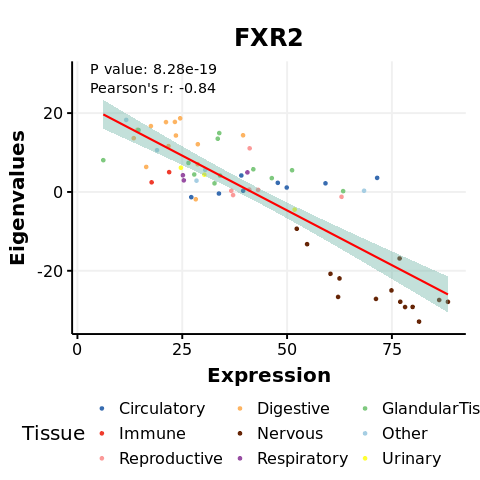

In [48]:
%%R
col_fun = colorRamp2(c(-4, 0, 4), c("blue", "white", "red"))
modules=read.csv('WGCNA/WGCNA_module_labels.csv',stringsAsFactors=F)
eigen_values=read.csv('WGCNA/WGCNA_Eigenvalues.csv',header=T,stringsAsFactors=F)
row.names(eigen_values)<-eigen_values[,1]
eigen_values<-eigen_values[-1]
# read in and preprocess gene expression
gene_exp<-read.table('m6A_data/FA233_exp_all_tx_mean.txt',sep='\t',header = T,row.names = 1,stringsAsFactors=F)
cvs<-apply(gene_exp,1,cv)
valid_exp<-subset(gene_exp,cvs>0)
ensg_gn<-unique(read.table('gtf/ensg_gn.txt',header=F,stringsAsFactors=F))
row.names(ensg_gn)<-ensg_gn$V1

target_rbp=c('FXR2')
module_indexes=modules[modules$x=='M6',]$X
module_exp<-valid_exp[ensg_gn[ensg_gn$V2 %in% target_rbp,]$V1,]
row.names(module_exp)<-as.character(ensg_gn[row.names(module_exp),'V2'])
spl<-t(as.data.frame(strsplit(colnames(module_exp),'_')))
colnames(spl)<-c('Group','Age','Tissue')
tissue_group<-as.vector(spl[,'Group'])
repl <- function(str){
    return(str_replace(str,'System',''))
}
tissue_group<-as.character(lapply(tissue_group,repl))

# pdf('figures/Figure4F_eigen_corr.pdf',height=8)

for(rbp in target_rbp){
    data<-data.frame(Expression=as.vector(t(module_exp[rbp,])),
          Eigenvalues=as.vector(t(eigen_values['M6',])),Tissue=tissue_group)
    tst<-cor.test(as.vector(t(module_exp[rbp,])),as.vector(t(eigen_values['M6',])))
    lmr<-lm(Expression ~ Eigenvalues, data = data)
    r<-tst$estimate
    pv<-tst$p.value
#     r2<-summary(lmr)$r.squared
#     pv<-summary(lmr)$coefficients[2,4]
    p3 <- ggplot(data, aes(x=Expression, y=Eigenvalues)) +
      geom_point(aes(color=Tissue)) +theme_Publication()+scale_fill_Publication()+scale_colour_Publication()+
      geom_smooth(method=lm , color="red", fill="#69b3a2", se=TRUE) +ggtitle(rbp)+
    annotate('text',label=paste0("P value: ",formatC(pv,format='e',digits=2)),
             hjust=0,vjust=0,x=3,y=30,parse = F,size=5)+
    annotate('text',label=paste0("Pearson's r: ", formatC(r,format='f',digits=2)),
             hjust=0,vjust=0,x=3,y=25,parse = F,size=5)+
    guides(color=guide_legend(nrow=3,byrow=TRUE))
    print(p3)
}
# dev.off()
